In [1]:
pip install tejapi

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
###三寶
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tejapi
tejapi.ApiConfig.api_key="XIVhEgCzNpR6UkFD7w9mBlV3sT5oJT"
from sklearn.preprocessing import MinMaxScaler

##################
from tqdm import tqdm, trange
#from tqdm.notebook import tqdm googlecolab
import tensorflow as tf 

from keras.layers.core import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Sequential
from keras.layers import LSTM,Bidirectional,GRU
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [3]:
def root_mean_squared_error(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred - y_true)))
    
    
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, single_step=False):
  data = []
  labels = []
  
  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size
  
  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    data.append(dataset[indices])
    
    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])
  
  return np.array(data), np.array(labels)


In [4]:
df = pd.read_csv("2330-2018to2022y.csv", index_col="日期")
df

,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數
日期,,,,,,,,
107/01/02,18055269,4188555408,231.5,232.5,231.0,232.5,3.0,9954
107/01/03,31706091,7504382512,236.0,238.0,235.5,237.0,4.5,13633
107/01/04,29179613,6963192636,240.0,240.0,236.5,239.5,2.5,10953
107/01/05,23721255,5681934695,240.0,240.0,238.0,240.0,0.5,8659
107/01/08,21846692,5281823362,242.0,242.5,240.5,242.0,2.0,10251
...,...,...,...,...,...,...,...,...
111/12/26,9152790,4171194858,454.0,457.0,453.5,456.5,+1.50,16718
111/12/27,10486219,4820155221,458.0,462.5,457.0,457.0,+0.50,13482
111/12/28,34823492,15643266841,451.0,452.0,446.0,451.0,-6.00,59400


In [5]:
df = df.drop(["漲跌價差","成交金額","成交筆數"], axis=1)

In [6]:
y = df["收盤價"]
x = df

In [7]:
y

日期
107/01/02    232.5
107/01/03    237.0
107/01/04    239.5
107/01/05    240.0
107/01/08    242.0
             ...  
111/12/26    456.5
111/12/27    457.0
111/12/28    451.0
111/12/29    446.0
111/12/30    448.5
Name: 收盤價, Length: 1224, dtype: float64

In [8]:
x

,成交股數,開盤價,最高價,最低價,收盤價
日期,,,,,
107/01/02,18055269,231.5,232.5,231.0,232.5
107/01/03,31706091,236.0,238.0,235.5,237.0
107/01/04,29179613,240.0,240.0,236.5,239.5
107/01/05,23721255,240.0,240.0,238.0,240.0
107/01/08,21846692,242.0,242.5,240.5,242.0
...,...,...,...,...,...
111/12/26,9152790,454.0,457.0,453.5,456.5
111/12/27,10486219,458.0,462.5,457.0,457.0
111/12/28,34823492,451.0,452.0,446.0,451.0


In [9]:
scaler=MinMaxScaler(feature_range=(0,1))
y=scaler.fit_transform(y.to_frame())
scaler1=MinMaxScaler(feature_range=(0,1))
x=scaler1.fit_transform(x)

In [10]:
x,y=multivariate_data( x ,y , 0 ,None, 10 , 1 ,single_step=True)
split =0.95
x_,y_  = x[0:int(split*len(x))] , y[0:int(split*len(x))]
x_test ,y_test   = x[int(split*len(x)):] , y[int(split*len(x)):]
split= 0.8
x_train,y_train  =x_[:int(split*len(x_))] , y_[:int(split*len(x_))]
x_vaild,y_vaild  =x_[int(split*len(x_)):] , y_[int(split*len(x_)):]

In [11]:
trainindex= df.index[10:len(x_train)+10]
valindex = df.index[len(x_train)+10:len(x_train)+10+len(x_vaild)]

In [12]:
print(x_train.shape,y_train.shape,x_vaild.shape,y_vaild.shape,)

(921, 10, 5) (921, 1) (231, 10, 5) (231, 1)


In [13]:
## 單層的LSTM
def lstm_model0(input_length, input_dim):

    d=0.3
    model= Sequential()
    model.add(LSTM(32,input_shape=(input_length, input_dim),return_sequences=False))
    model.add(Dropout(d))
   
    model.add(Dense(1,activation='linear'))#linear / softmax(多分類) / sigmoid(二分法)

    # optimizer = tf.keras.optimizers.Adam(lr=0.00005)
    model.compile(loss='mse',optimizer='adam')#loss=mse/categorical_crossentropy
    return model 

In [17]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=300, monitor = 'val_loss')
    ]
filepath="lstm.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, mode='min',save_best_only=True)

call_backlist = [ my_callbacks,checkpoint]
callbacks=call_backlist
lstm00 = lstm_model0(10,5)

In [20]:
historylstm0 = lstm00.fit( x_train, y_train, batch_size=30,shuffle=False , epochs=1000,validation_data=(x_vaild,y_vaild),callbacks=call_backlist)
lstm00.summary()

Epoch 1/1000
21/31 [===================>..........] - ETA: 0s - loss: 0.0034
Epoch 1: val_loss improved from inf to 0.00247, saving model to lstm.best.hdf5
31/31 [==============================] - 2s 21ms/step - loss: 0.0115 - val_loss: 0.0025
Epoch 2/1000
22/31 [====================>.........] - ETA: 0s - loss: 0.0053
Epoch 2: val_loss did not improve from 0.00247
31/31 [==============================] - 0s 6ms/step - loss: 0.0118 - val_loss: 0.0091
Epoch 3/1000
22/31 [====================>.........] - ETA: 0s - loss: 0.0033
Epoch 3: val_loss did not improve from 0.00247
31/31 [==============================] - 0s 6ms/step - loss: 0.0095 - val_loss: 0.0071
Epoch 4/1000
21/31 [===================>..........] - ETA: 0s - loss: 0.0019
Epoch 4: val_loss improved from 0.00247 to 0.00222, saving model to lstm.best.hdf5
31/31 [==============================] - 0s 7ms/step - loss: 0.0062 - val_loss: 0.0022
Epoch 5/1000
22/31 [====================>.........] - ETA: 0s - loss: 0.0019    
Epoch 

31/31 [==============================] - 0s 7ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 38/1000
21/31 [===================>..........] - ETA: 0s - loss: 4.8742e-04
Epoch 38: val_loss did not improve from 0.00114
31/31 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 39/1000
22/31 [====================>.........] - ETA: 0s - loss: 6.4363e-04
Epoch 39: val_loss did not improve from 0.00114
31/31 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 40/1000
22/31 [====================>.........] - ETA: 0s - loss: 5.9028e-04
Epoch 40: val_loss did not improve from 0.00114
31/31 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 41/1000
22/31 [====================>.........] - ETA: 0s - loss: 6.3226e-04
Epoch 41: val_loss did not improve from 0.00114
31/31 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 42/1000
31/31 [========================

Epoch 75/1000
23/31 [=====================>........] - ETA: 0s - loss: 6.4867e-04
Epoch 75: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 76/1000
23/31 [=====================>........] - ETA: 0s - loss: 6.6856e-04
Epoch 76: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 6ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 77/1000
22/31 [====================>.........] - ETA: 0s - loss: 6.5211e-04
Epoch 77: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 78/1000
22/31 [====================>.........] - ETA: 0s - loss: 6.6316e-04
Epoch 78: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 79/1000
22/31 [====================>.........] - ETA: 0s - loss: 6.2025e-04
Epoch 79: val_loss did not improve from 0.00101
31

31/31 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 113/1000
28/31 [==========================>...] - ETA: 0s - loss: 0.0016    
Epoch 113: val_loss did not improve from 0.00096
31/31 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 114/1000
27/31 [=========================>....] - ETA: 0s - loss: 0.0014    
Epoch 114: val_loss improved from 0.00096 to 0.00096, saving model to lstm.best.hdf5
31/31 [==============================] - 0s 9ms/step - loss: 0.0017 - val_loss: 9.5886e-04
Epoch 115/1000
27/31 [=========================>....] - ETA: 0s - loss: 0.0014    
Epoch 115: val_loss improved from 0.00096 to 0.00095, saving model to lstm.best.hdf5
31/31 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 9.4919e-04
Epoch 116/1000
28/31 [==========================>...] - ETA: 0s - loss: 0.0014    
Epoch 116: val_loss did not improve from 0.00095
31/31 [==============================] - 0s 

29/31 [===========================>..] - ETA: 0s - loss: 0.0015    
Epoch 149: val_loss did not improve from 0.00093
31/31 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 9.9247e-04
Epoch 150/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0018    
Epoch 150: val_loss improved from 0.00093 to 0.00091, saving model to lstm.best.hdf5
31/31 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 9.0848e-04
Epoch 151/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0017    
Epoch 151: val_loss did not improve from 0.00091
31/31 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 152/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0016    
Epoch 152: val_loss did not improve from 0.00091
31/31 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 153/1000
27/31 [=========================>....] - ETA: 0s - loss: 0.0016    
Epoch 153: v

31/31 [==============================] - ETA: 0s - loss: 0.0014    
Epoch 186: val_loss improved from 0.00090 to 0.00087, saving model to lstm.best.hdf5
31/31 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 8.6947e-04
Epoch 187/1000
31/31 [==============================] - ETA: 0s - loss: 0.0015    
Epoch 187: val_loss did not improve from 0.00087
31/31 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 188/1000
31/31 [==============================] - ETA: 0s - loss: 0.0017    
Epoch 188: val_loss did not improve from 0.00087
31/31 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 8.8556e-04
Epoch 189/1000
31/31 [==============================] - ETA: 0s - loss: 0.0018    
Epoch 189: val_loss did not improve from 0.00087
31/31 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 8.7020e-04
Epoch 190/1000
23/31 [=====================>........] - ETA: 0s - loss: 7.5193e-04
Epoch 19

Epoch 223/1000
31/31 [==============================] - ETA: 0s - loss: 0.0018    
Epoch 223: val_loss did not improve from 0.00084
31/31 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 224/1000
31/31 [==============================] - ETA: 0s - loss: 0.0018    
Epoch 224: val_loss did not improve from 0.00084
31/31 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 8.9308e-04
Epoch 225/1000
28/31 [==========================>...] - ETA: 0s - loss: 0.0015    
Epoch 225: val_loss did not improve from 0.00084
31/31 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 8.8220e-04
Epoch 226/1000
26/31 [========================>.....] - ETA: 0s - loss: 0.0015
Epoch 226: val_loss did not improve from 0.00084
31/31 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 9.7241e-04
Epoch 227/1000
25/31 [=======================>......] - ETA: 0s - loss: 0.0012    
Epoch 227: val_loss did not impro

21/31 [===================>..........] - ETA: 0s - loss: 8.5668e-04
Epoch 260: val_loss did not improve from 0.00084
31/31 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 9.2599e-04
Epoch 261/1000
31/31 [==============================] - ETA: 0s - loss: 0.0016    
Epoch 261: val_loss did not improve from 0.00084
31/31 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 9.0900e-04
Epoch 262/1000
22/31 [====================>.........] - ETA: 0s - loss: 9.0912e-04
Epoch 262: val_loss did not improve from 0.00084
31/31 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 263/1000
23/31 [=====================>........] - ETA: 0s - loss: 9.5641e-04
Epoch 263: val_loss did not improve from 0.00084
31/31 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 8.9945e-04
Epoch 264/1000
21/31 [===================>..........] - ETA: 0s - loss: 9.3771e-04
Epoch 264: val_loss did not improve from 0.0

Epoch 297/1000
28/31 [==========================>...] - ETA: 0s - loss: 0.0015    
Epoch 297: val_loss did not improve from 0.00083
31/31 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 8.7719e-04
Epoch 298/1000
26/31 [========================>.....] - ETA: 0s - loss: 0.0013    
Epoch 298: val_loss did not improve from 0.00083
31/31 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 9.1023e-04
Epoch 299/1000
26/31 [========================>.....] - ETA: 0s - loss: 0.0013    
Epoch 299: val_loss did not improve from 0.00083
31/31 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 8.8833e-04
Epoch 300/1000
25/31 [=======================>......] - ETA: 0s - loss: 0.0012    
Epoch 300: val_loss did not improve from 0.00083
31/31 [==============================] - 0s 9ms/step - loss: 0.0016 - val_loss: 8.7190e-04
Epoch 301/1000
27/31 [=========================>....] - ETA: 0s - loss: 0.0013    
Epoch 301: val_loss did n

Epoch 334/1000
26/31 [========================>.....] - ETA: 0s - loss: 0.0013    
Epoch 334: val_loss did not improve from 0.00083
31/31 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 8.4723e-04
Epoch 335/1000
25/31 [=======================>......] - ETA: 0s - loss: 0.0014    
Epoch 335: val_loss did not improve from 0.00083
31/31 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 336/1000
28/31 [==========================>...] - ETA: 0s - loss: 0.0016
Epoch 336: val_loss did not improve from 0.00083
31/31 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 337/1000
28/31 [==========================>...] - ETA: 0s - loss: 0.0016
Epoch 337: val_loss did not improve from 0.00083
31/31 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 338/1000
21/31 [===================>..........] - ETA: 0s - loss: 9.9496e-04
Epoch 338: val_loss did not improve from 0.00

28/31 [==========================>...] - ETA: 0s - loss: 0.0024
Epoch 371: val_loss did not improve from 0.00083
31/31 [==============================] - 0s 8ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 372/1000
28/31 [==========================>...] - ETA: 0s - loss: 0.0022
Epoch 372: val_loss did not improve from 0.00083
31/31 [==============================] - 0s 8ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 373/1000
28/31 [==========================>...] - ETA: 0s - loss: 0.0023
Epoch 373: val_loss did not improve from 0.00083
31/31 [==============================] - 0s 8ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 374/1000
28/31 [==========================>...] - ETA: 0s - loss: 0.0026
Epoch 374: val_loss did not improve from 0.00083
31/31 [==============================] - 0s 8ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 375/1000
28/31 [==========================>...] - ETA: 0s - loss: 0.0033
Epoch 375: val_loss did not improve from 0.00083
31/31 [====================

31/31 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 9.1710e-04
Epoch 409/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0019
Epoch 409: val_loss did not improve from 0.00082
31/31 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 8.2607e-04
Epoch 410/1000
29/31 [===========================>..] - ETA: 0s - loss: 0.0020
Epoch 410: val_loss did not improve from 0.00082
31/31 [==============================] - 0s 7ms/step - loss: 0.0022 - val_loss: 8.8756e-04
Epoch 411/1000
29/31 [===========================>..] - ETA: 0s - loss: 0.0017
Epoch 411: val_loss improved from 0.00082 to 0.00081, saving model to lstm.best.hdf5
31/31 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 8.0989e-04
Epoch 412/1000
29/31 [===========================>..] - ETA: 0s - loss: 0.0019
Epoch 412: val_loss did not improve from 0.00081
31/31 [==============================] - 0s 7ms/step - loss: 0.0021 - val_loss: 8.7656e-

26/31 [========================>.....] - ETA: 0s - loss: 0.0018
Epoch 446: val_loss did not improve from 0.00081
31/31 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 8.8581e-04
Epoch 447/1000
28/31 [==========================>...] - ETA: 0s - loss: 0.0019  
Epoch 447: val_loss did not improve from 0.00081
31/31 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 8.5220e-04
Epoch 448/1000
28/31 [==========================>...] - ETA: 0s - loss: 0.0020  
Epoch 448: val_loss did not improve from 0.00081
31/31 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 449/1000
28/31 [==========================>...] - ETA: 0s - loss: 0.0021
Epoch 449: val_loss did not improve from 0.00081
31/31 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 8.1203e-04
Epoch 450/1000
28/31 [==========================>...] - ETA: 0s - loss: 0.0018
Epoch 450: val_loss did not improve from 0.00081
31/31 [====

31/31 [==============================] - ETA: 0s - loss: 0.0022  
Epoch 483: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 7ms/step - loss: 0.0022 - val_loss: 7.9910e-04
Epoch 484/1000
26/31 [========================>.....] - ETA: 0s - loss: 0.0017
Epoch 484: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 9.2330e-04
Epoch 485/1000
25/31 [=======================>......] - ETA: 0s - loss: 0.0015
Epoch 485: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 8.2691e-04
Epoch 486/1000
29/31 [===========================>..] - ETA: 0s - loss: 0.0017
Epoch 486: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 8.7448e-04
Epoch 487/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0020
Epoch 487: val_loss did not improve from 0.00079
31/31 [==

31/31 [==============================] - ETA: 0s - loss: 0.0025
Epoch 520: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 7ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 521/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0023
Epoch 521: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 7ms/step - loss: 0.0023 - val_loss: 8.0739e-04
Epoch 522/1000
28/31 [==========================>...] - ETA: 0s - loss: 0.0019
Epoch 522: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 9.2430e-04
Epoch 523/1000
28/31 [==========================>...] - ETA: 0s - loss: 0.0020
Epoch 523: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 8ms/step - loss: 0.0022 - val_loss: 8.2044e-04
Epoch 524/1000
28/31 [==========================>...] - ETA: 0s - loss: 0.0019
Epoch 524: val_loss did not improve from 0.00079
31/31 [========

31/31 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 8.2328e-04
Epoch 558/1000
31/31 [==============================] - ETA: 0s - loss: 0.0022
Epoch 558: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 7ms/step - loss: 0.0022 - val_loss: 8.7768e-04
Epoch 559/1000
31/31 [==============================] - ETA: 0s - loss: 0.0020
Epoch 559: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 7ms/step - loss: 0.0020 - val_loss: 8.0860e-04
Epoch 560/1000
31/31 [==============================] - ETA: 0s - loss: 0.0021
Epoch 560: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 7ms/step - loss: 0.0021 - val_loss: 9.1829e-04
Epoch 561/1000
31/31 [==============================] - ETA: 0s - loss: 0.0022
Epoch 561: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 7ms/step - loss: 0.0022 - val_loss: 8.1322e-04
Epoch 562/1000
22/31 [===========

Epoch 595/1000
31/31 [==============================] - ETA: 0s - loss: 0.0025
Epoch 595: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 7ms/step - loss: 0.0025 - val_loss: 8.0126e-04
Epoch 596/1000
31/31 [==============================] - ETA: 0s - loss: 0.0024
Epoch 596: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 7ms/step - loss: 0.0024 - val_loss: 0.0010
Epoch 597/1000
31/31 [==============================] - ETA: 0s - loss: 0.0023
Epoch 597: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 7ms/step - loss: 0.0023 - val_loss: 8.0932e-04
Epoch 598/1000
31/31 [==============================] - ETA: 0s - loss: 0.0023
Epoch 598: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 7ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 599/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0022
Epoch 599: val_loss did not improve from 0.00079
31/3

31/31 [==============================] - 0s 7ms/step - loss: 0.0028 - val_loss: 0.0010
Epoch 633/1000
31/31 [==============================] - ETA: 0s - loss: 0.0029
Epoch 633: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 8.1357e-04
Epoch 634/1000
29/31 [===========================>..] - ETA: 0s - loss: 0.0027
Epoch 634: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 8ms/step - loss: 0.0027 - val_loss: 9.7830e-04
Epoch 635/1000
28/31 [==========================>...] - ETA: 0s - loss: 0.0024
Epoch 635: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 8ms/step - loss: 0.0024 - val_loss: 8.4287e-04
Epoch 636/1000
27/31 [=========================>....] - ETA: 0s - loss: 0.0023
Epoch 636: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 8ms/step - loss: 0.0026 - val_loss: 9.9562e-04
Epoch 637/1000
28/31 [===============

Epoch 670/1000
28/31 [==========================>...] - ETA: 0s - loss: 0.0016
Epoch 670: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 8.3978e-04
Epoch 671/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 671: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 8.4378e-04
Epoch 672/1000
31/31 [==============================] - ETA: 0s - loss: 0.0019    
Epoch 672: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 8.3514e-04
Epoch 673/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0019
Epoch 673: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 8.9257e-04
Epoch 674/1000
28/31 [==========================>...] - ETA: 0s - loss: 0.0021
Epoch 674: val_loss did not improve from 

31/31 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 7.9680e-04
Epoch 708/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 708: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 8.6792e-04
Epoch 709/1000
29/31 [===========================>..] - ETA: 0s - loss: 0.0018 
Epoch 709: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 8.0275e-04
Epoch 710/1000
25/31 [=======================>......] - ETA: 0s - loss: 0.0013    
Epoch 710: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 8.3755e-04
Epoch 711/1000
25/31 [=======================>......] - ETA: 0s - loss: 0.0013
Epoch 711: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 9ms/step - loss: 0.0022 - val_loss: 9.6569e-04
Epoch 712/1000
25/31 [===

Epoch 745/1000
31/31 [==============================] - ETA: 0s - loss: 0.0018
Epoch 745: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 8.0920e-04
Epoch 746/1000
25/31 [=======================>......] - ETA: 0s - loss: 0.0015
Epoch 746: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 8.4074e-04
Epoch 747/1000
25/31 [=======================>......] - ETA: 0s - loss: 0.0014
Epoch 747: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 8.2029e-04
Epoch 748/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0020
Epoch 748: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 8.5095e-04
Epoch 749/1000
24/31 [======================>.......] - ETA: 0s - loss: 0.0014
Epoch 749: val_loss did not improve from 0.00

31/31 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 9.3280e-04
Epoch 783/1000
25/31 [=======================>......] - ETA: 0s - loss: 0.0014
Epoch 783: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 8.2290e-04
Epoch 784/1000
28/31 [==========================>...] - ETA: 0s - loss: 0.0020
Epoch 784: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 8ms/step - loss: 0.0022 - val_loss: 8.7357e-04
Epoch 785/1000
25/31 [=======================>......] - ETA: 0s - loss: 0.0016
Epoch 785: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 8ms/step - loss: 0.0022 - val_loss: 8.4175e-04
Epoch 786/1000
27/31 [=========================>....] - ETA: 0s - loss: 0.0019
Epoch 786: val_loss did not improve from 0.00079
31/31 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 9.6074e-04
Epoch 787/1000
27/31 [===========

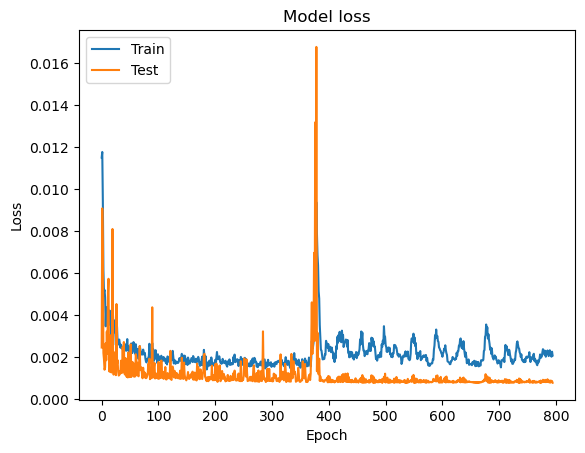

In [21]:
plt.plot(historylstm0.history['loss'])
plt.plot(historylstm0.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

8/8 [==============================] - 0s 3ms/step


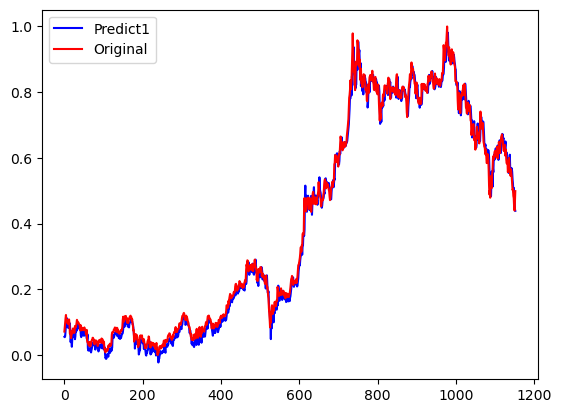

In [22]:
lstm0train  = lstm00.predict(x_train)
lstm0val = lstm00.predict(x_vaild)
lstm0pre = lstm00.predict(x_test)
pre = lstm00.predict(x_train)
pre1=lstm00.predict(x_vaild)
fc=np.concatenate((pre,pre1))
yreal=np.concatenate((y_train,y_vaild))
plt.figure(facecolor='white')
pd.Series(fc.reshape(-1)).plot(color='blue', label='Predict1')
pd.Series(yreal.reshape(-1)).plot(color='red', label='Original')
plt.legend()
plt.show()

C:\Users\terry\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\terry\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 20729 (\N{CJK UNIFIED IDEOGRAPH-50F9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


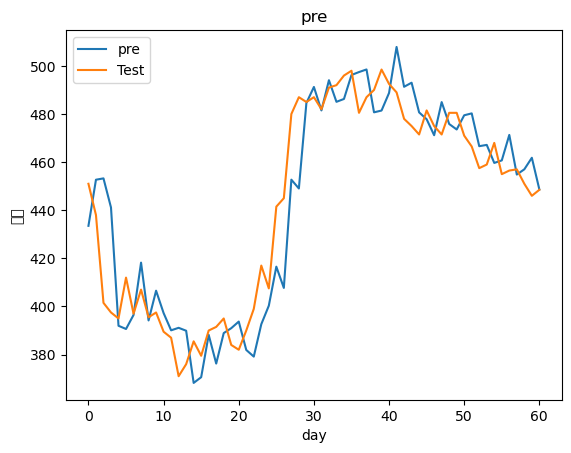

16.104220147500122

In [23]:
lstm0pre= scaler.inverse_transform(lstm0pre)#將資料轉換回來
y_test = scaler.inverse_transform(y_test.reshape(-1,1))
plt.figure()
plt.plot(lstm0pre)
plt.plot(y_test)
plt.title('pre')
plt.ylabel('股價')
plt.xlabel('day')
plt.legend(['pre', 'Test'], loc='upper left')
plt.show()
root_mean_squared_error(lstm0pre,y_test)

In [24]:
## 兩層 LSTM
def lstm_model(input_length, input_dim):

    d=0.3
    model= Sequential()
    model.add(LSTM(64,input_shape=(input_length, input_dim),return_sequences=True))
    model.add(Dropout(d))

    model.add(LSTM(32,input_shape=(input_length, input_dim),return_sequences=False))
    model.add(Dropout(d))
    
    model.add(Dense(1,activation='linear'))#linear / softmax(多分類) / sigmoid(二分法)

    # optimizer = tf.keras.optimizers.Adam(lr=0.00005)
    model.compile(loss='mse',optimizer='adam')#loss=mse/categorical_crossentropy
    return model 

In [25]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=300, monitor = 'val_loss')
    ]
filepath="lstm.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, mode='min',save_best_only=True)

call_backlist = [ my_callbacks,checkpoint]
callbacks=call_backlist
lstm0 = lstm_model(10,5)
historylstm0 = lstm0.fit( x_train, y_train, batch_size=30,shuffle=False , epochs=1000,validation_data=(x_vaild,y_vaild),callbacks=call_backlist)
lstm0.summary()

Epoch 1/1000
29/31 [===========================>..] - ETA: 0s - loss: 0.0076
Epoch 1: val_loss improved from inf to 0.00374, saving model to lstm.best.hdf5
31/31 [==============================] - 4s 34ms/step - loss: 0.0082 - val_loss: 0.0037
Epoch 2/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0102
Epoch 2: val_loss did not improve from 0.00374
31/31 [==============================] - 0s 11ms/step - loss: 0.0102 - val_loss: 0.0057
Epoch 3/1000
31/31 [==============================] - ETA: 0s - loss: 0.0175
Epoch 3: val_loss did not improve from 0.00374
31/31 [==============================] - 0s 11ms/step - loss: 0.0175 - val_loss: 0.0209
Epoch 4/1000
31/31 [==============================] - ETA: 0s - loss: 0.0117
Epoch 4: val_loss did not improve from 0.00374
31/31 [==============================] - 0s 11ms/step - loss: 0.0117 - val_loss: 0.0349
Epoch 5/1000
31/31 [==============================] - ETA: 0s - loss: 0.0087
Epoch 5: val_loss improved from 0.00374 to 

31/31 [==============================] - 0s 11ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 38/1000
29/31 [===========================>..] - ETA: 0s - loss: 0.0047
Epoch 38: val_loss did not improve from 0.00148
31/31 [==============================] - 0s 11ms/step - loss: 0.0049 - val_loss: 0.0017
Epoch 39/1000
31/31 [==============================] - ETA: 0s - loss: 0.0050
Epoch 39: val_loss did not improve from 0.00148
31/31 [==============================] - 0s 11ms/step - loss: 0.0050 - val_loss: 0.0018
Epoch 40/1000
31/31 [==============================] - ETA: 0s - loss: 0.0040   
Epoch 40: val_loss did not improve from 0.00148
31/31 [==============================] - 0s 11ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 41/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0029   
Epoch 41: val_loss did not improve from 0.00148
31/31 [==============================] - 0s 11ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 42/1000
30/31 [============================>

Epoch 75/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0028    
Epoch 75: val_loss did not improve from 0.00125
31/31 [==============================] - 0s 11ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 76/1000
31/31 [==============================] - ETA: 0s - loss: 0.0025   
Epoch 76: val_loss did not improve from 0.00125
31/31 [==============================] - 0s 11ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 77/1000
31/31 [==============================] - ETA: 0s - loss: 0.0025   
Epoch 77: val_loss did not improve from 0.00125
31/31 [==============================] - 0s 11ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 78/1000
31/31 [==============================] - ETA: 0s - loss: 0.0026   
Epoch 78: val_loss did not improve from 0.00125
31/31 [==============================] - 0s 11ms/step - loss: 0.0026 - val_loss: 0.0045
Epoch 79/1000
31/31 [==============================] - ETA: 0s - loss: 0.0031  
Epoch 79: val_loss did not improve from 0.00125
31/

31/31 [==============================] - 0s 11ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 113/1000
31/31 [==============================] - ETA: 0s - loss: 0.0022   
Epoch 113: val_loss did not improve from 0.00115
31/31 [==============================] - 0s 11ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 114/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0021   
Epoch 114: val_loss did not improve from 0.00115
31/31 [==============================] - 0s 11ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 115/1000
29/31 [===========================>..] - ETA: 0s - loss: 0.0018   
Epoch 115: val_loss did not improve from 0.00115
31/31 [==============================] - 0s 11ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 116/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0024    
Epoch 116: val_loss did not improve from 0.00115
31/31 [==============================] - 0s 11ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 117/1000
31/31 [=============

29/31 [===========================>..] - ETA: 0s - loss: 0.0020    
Epoch 150: val_loss did not improve from 0.00115
31/31 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 151/1000
31/31 [==============================] - ETA: 0s - loss: 0.0019   
Epoch 151: val_loss did not improve from 0.00115
31/31 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 152/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0020   
Epoch 152: val_loss did not improve from 0.00115
31/31 [==============================] - 0s 11ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 153/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0018    
Epoch 153: val_loss did not improve from 0.00115
31/31 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 154/1000
31/31 [==============================] - ETA: 0s - loss: 0.0025   
Epoch 154: val_loss did not improve from 0.00115
31/31 

31/31 [==============================] - 0s 12ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 188/1000
31/31 [==============================] - ETA: 0s - loss: 0.0019   
Epoch 188: val_loss did not improve from 0.00113
31/31 [==============================] - 0s 12ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 189/1000
27/31 [=========================>....] - ETA: 0s - loss: 0.0017    
Epoch 189: val_loss did not improve from 0.00113
31/31 [==============================] - 0s 12ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 190/1000
31/31 [==============================] - ETA: 0s - loss: 0.0020   
Epoch 190: val_loss did not improve from 0.00113
31/31 [==============================] - 0s 12ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 191/1000
31/31 [==============================] - ETA: 0s - loss: 0.0019   
Epoch 191: val_loss did not improve from 0.00113
31/31 [==============================] - 0s 12ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 192/1000
31/31 [=============

Epoch 225/1000
31/31 [==============================] - ETA: 0s - loss: 0.0023
Epoch 225: val_loss did not improve from 0.00111
31/31 [==============================] - 0s 12ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 226/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0021
Epoch 226: val_loss did not improve from 0.00111
31/31 [==============================] - 0s 13ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 227/1000
31/31 [==============================] - ETA: 0s - loss: 0.0019
Epoch 227: val_loss did not improve from 0.00111
31/31 [==============================] - 0s 13ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 228/1000
31/31 [==============================] - ETA: 0s - loss: 0.0022
Epoch 228: val_loss did not improve from 0.00111
31/31 [==============================] - 0s 13ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 229/1000
31/31 [==============================] - ETA: 0s - loss: 0.0023
Epoch 229: val_loss did not improve from 0.00111
31/31 [=

Epoch 263/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0020   
Epoch 263: val_loss did not improve from 0.00107
31/31 [==============================] - 0s 14ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 264/1000
28/31 [==========================>...] - ETA: 0s - loss: 0.0017
Epoch 264: val_loss did not improve from 0.00107
31/31 [==============================] - 0s 15ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 265/1000
27/31 [=========================>....] - ETA: 0s - loss: 0.0016    
Epoch 265: val_loss did not improve from 0.00107
31/31 [==============================] - 0s 15ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 266/1000
28/31 [==========================>...] - ETA: 0s - loss: 0.0018   
Epoch 266: val_loss did not improve from 0.00107
31/31 [==============================] - 0s 15ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 267/1000
28/31 [==========================>...] - ETA: 0s - loss: 0.0021
Epoch 267: val_loss did not improve from 0.0010

Epoch 301/1000
31/31 [==============================] - ETA: 0s - loss: 0.0023
Epoch 301: val_loss did not improve from 0.00107
31/31 [==============================] - 0s 13ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 302/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0023
Epoch 302: val_loss did not improve from 0.00107
31/31 [==============================] - 0s 14ms/step - loss: 0.0023 - val_loss: 0.0045
Epoch 303/1000
31/31 [==============================] - ETA: 0s - loss: 0.0023
Epoch 303: val_loss did not improve from 0.00107
31/31 [==============================] - 0s 13ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 304/1000
31/31 [==============================] - ETA: 0s - loss: 0.0023
Epoch 304: val_loss did not improve from 0.00107
31/31 [==============================] - 0s 13ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 305/1000
31/31 [==============================] - ETA: 0s - loss: 0.0023
Epoch 305: val_loss did not improve from 0.00107
31/31 [=

Epoch 339/1000
31/31 [==============================] - ETA: 0s - loss: 0.0019   
Epoch 339: val_loss did not improve from 0.00107
31/31 [==============================] - 0s 13ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 340/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0019   
Epoch 340: val_loss did not improve from 0.00107
31/31 [==============================] - 0s 14ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 341/1000
31/31 [==============================] - ETA: 0s - loss: 0.0021
Epoch 341: val_loss did not improve from 0.00107
31/31 [==============================] - 0s 13ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 342/1000
31/31 [==============================] - ETA: 0s - loss: 0.0018
Epoch 342: val_loss did not improve from 0.00107
31/31 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 343/1000
31/31 [==============================] - ETA: 0s - loss: 0.0018   
Epoch 343: val_loss did not improve from 0.00107

31/31 [==============================] - 0s 15ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 377/1000
31/31 [==============================] - ETA: 0s - loss: 0.0020
Epoch 377: val_loss did not improve from 0.00103
31/31 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 378/1000
31/31 [==============================] - ETA: 0s - loss: 0.0018   
Epoch 378: val_loss did not improve from 0.00103
31/31 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 379/1000
31/31 [==============================] - ETA: 0s - loss: 0.0022
Epoch 379: val_loss did not improve from 0.00103
31/31 [==============================] - 0s 16ms/step - loss: 0.0022 - val_loss: 0.0043
Epoch 380/1000
31/31 [==============================] - ETA: 0s - loss: 0.0021
Epoch 380: val_loss did not improve from 0.00103
31/31 [==============================] - 0s 14ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 381/1000
31/31 [=======================

31/31 [==============================] - ETA: 0s - loss: 0.0018
Epoch 414: val_loss did not improve from 0.00103
31/31 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 415/1000
31/31 [==============================] - ETA: 0s - loss: 0.0020
Epoch 415: val_loss did not improve from 0.00103
31/31 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 416/1000
31/31 [==============================] - ETA: 0s - loss: 0.0019
Epoch 416: val_loss did not improve from 0.00103
31/31 [==============================] - 0s 13ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 417/1000
31/31 [==============================] - ETA: 0s - loss: 0.0019
Epoch 417: val_loss did not improve from 0.00103
31/31 [==============================] - 0s 13ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 418/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0021   
Epoch 418: val_loss did not improve from 0.00103
31/31 [=============

Epoch 452/1000
31/31 [==============================] - ETA: 0s - loss: 0.0018
Epoch 452: val_loss did not improve from 0.00103
31/31 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 453/1000
31/31 [==============================] - ETA: 0s - loss: 0.0019   
Epoch 453: val_loss did not improve from 0.00103
31/31 [==============================] - 0s 13ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 454/1000
31/31 [==============================] - ETA: 0s - loss: 0.0020
Epoch 454: val_loss did not improve from 0.00103
31/31 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 455/1000
31/31 [==============================] - ETA: 0s - loss: 0.0020
Epoch 455: val_loss did not improve from 0.00103
31/31 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 456/1000
31/31 [==============================] - ETA: 0s - loss: 0.0018   
Epoch 456: val_loss did not improve from 0.00103
31

Epoch 490/1000
31/31 [==============================] - ETA: 0s - loss: 0.0016   
Epoch 490: val_loss did not improve from 0.00103
31/31 [==============================] - 0s 13ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 491/1000
31/31 [==============================] - ETA: 0s - loss: 0.0020
Epoch 491: val_loss did not improve from 0.00103
31/31 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 492/1000
31/31 [==============================] - ETA: 0s - loss: 0.0018
Epoch 492: val_loss did not improve from 0.00103
31/31 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 493/1000
31/31 [==============================] - ETA: 0s - loss: 0.0021
Epoch 493: val_loss did not improve from 0.00103
31/31 [==============================] - 0s 13ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 494/1000
31/31 [==============================] - ETA: 0s - loss: 0.0019   
Epoch 494: val_loss did not improve from 0.00103
31

Epoch 528/1000
31/31 [==============================] - ETA: 0s - loss: 0.0020
Epoch 528: val_loss improved from 0.00103 to 0.00101, saving model to lstm.best.hdf5
31/31 [==============================] - 0s 14ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 529/1000
31/31 [==============================] - ETA: 0s - loss: 0.0020
Epoch 529: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 530/1000
31/31 [==============================] - ETA: 0s - loss: 0.0021
Epoch 530: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 531/1000
31/31 [==============================] - ETA: 0s - loss: 0.0016   
Epoch 531: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 532/1000
31/31 [==============================] - ETA: 0s - loss: 0.0019   
Epoch 532: val_

31/31 [==============================] - 0s 13ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 566/1000
31/31 [==============================] - ETA: 0s - loss: 0.0016   
Epoch 566: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 567/1000
31/31 [==============================] - ETA: 0s - loss: 0.0018   
Epoch 567: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 568/1000
31/31 [==============================] - ETA: 0s - loss: 0.0017   
Epoch 568: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 569/1000
31/31 [==============================] - ETA: 0s - loss: 0.0018   
Epoch 569: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 570/1000
31/31 [==============

31/31 [==============================] - ETA: 0s - loss: 0.0022
Epoch 603: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 604/1000
31/31 [==============================] - ETA: 0s - loss: 0.0017   
Epoch 604: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 605/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0017   
Epoch 605: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 606/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0017   
Epoch 606: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 607/1000
31/31 [==============================] - ETA: 0s - loss: 0.0015   
Epoch 607: val_loss did not improve from 0.00101
31/31 [====

Epoch 641/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0018   
Epoch 641: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 642/1000
31/31 [==============================] - ETA: 0s - loss: 0.0016   
Epoch 642: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 643/1000
31/31 [==============================] - ETA: 0s - loss: 0.0017   
Epoch 643: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 14ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 644/1000
31/31 [==============================] - ETA: 0s - loss: 0.0019   
Epoch 644: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 14ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 645/1000
31/31 [==============================] - ETA: 0s - loss: 0.0018   
Epoch 645: val_loss did not improve from 0

Epoch 679/1000
29/31 [===========================>..] - ETA: 0s - loss: 0.0018   
Epoch 679: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 16ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 680/1000
31/31 [==============================] - ETA: 0s - loss: 0.0017   
Epoch 680: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 681/1000
31/31 [==============================] - ETA: 0s - loss: 0.0020
Epoch 681: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 682/1000
31/31 [==============================] - ETA: 0s - loss: 0.0016
Epoch 682: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 683/1000
31/31 [==============================] - ETA: 0s - loss: 0.0023
Epoch 683: val_loss did not improve from 0.00101
31

Epoch 717/1000
31/31 [==============================] - ETA: 0s - loss: 0.0016   
Epoch 717: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 718/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0019
Epoch 718: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 16ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 719/1000
31/31 [==============================] - ETA: 0s - loss: 0.0020   
Epoch 719: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 14ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 720/1000
31/31 [==============================] - ETA: 0s - loss: 0.0024
Epoch 720: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0024 - val_loss: 0.0046
Epoch 721/1000
31/31 [==============================] - ETA: 0s - loss: 0.0026
Epoch 721: val_loss did not improve from 0.00101
31

31/31 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 755/1000
31/31 [==============================] - ETA: 0s - loss: 0.0018
Epoch 755: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 756/1000
31/31 [==============================] - ETA: 0s - loss: 0.0019
Epoch 756: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 757/1000
31/31 [==============================] - ETA: 0s - loss: 0.0016   
Epoch 757: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 14ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 758/1000
31/31 [==============================] - ETA: 0s - loss: 0.0017   
Epoch 758: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 759/1000
31/31 [====================

30/31 [============================>.] - ETA: 0s - loss: 0.0019
Epoch 792: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 793/1000
31/31 [==============================] - ETA: 0s - loss: 0.0016   
Epoch 793: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 794/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0018   
Epoch 794: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 795/1000
31/31 [==============================] - ETA: 0s - loss: 0.0021
Epoch 795: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 796/1000
31/31 [==============================] - ETA: 0s - loss: 0.0018
Epoch 796: val_loss did not improve from 0.00101
31/31 [==========

Epoch 830/1000
31/31 [==============================] - ETA: 0s - loss: 0.0022
Epoch 830: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 831/1000
31/31 [==============================] - ETA: 0s - loss: 0.0019
Epoch 831: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 832/1000
31/31 [==============================] - ETA: 0s - loss: 0.0019
Epoch 832: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 833/1000
31/31 [==============================] - ETA: 0s - loss: 0.0018
Epoch 833: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 834/1000
31/31 [==============================] - ETA: 0s - loss: 0.0017   
Epoch 834: val_loss did not improve from 0.00101
31/31

Epoch 868/1000
31/31 [==============================] - ETA: 0s - loss: 0.0020   
Epoch 868: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 869/1000
31/31 [==============================] - ETA: 0s - loss: 0.0019
Epoch 869: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 870/1000
31/31 [==============================] - ETA: 0s - loss: 0.0021
Epoch 870: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 871/1000
31/31 [==============================] - ETA: 0s - loss: 0.0018   
Epoch 871: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 872/1000
31/31 [==============================] - ETA: 0s - loss: 0.0018
Epoch 872: val_loss did not improve from 0.00101
31

Epoch 906/1000
31/31 [==============================] - ETA: 0s - loss: 0.0020
Epoch 906: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 907/1000
31/31 [==============================] - ETA: 0s - loss: 0.0019
Epoch 907: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 908/1000
31/31 [==============================] - ETA: 0s - loss: 0.0019
Epoch 908: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 909/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0021
Epoch 909: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 14ms/step - loss: 0.0022 - val_loss: 0.0037
Epoch 910/1000
31/31 [==============================] - ETA: 0s - loss: 0.0024
Epoch 910: val_loss did not improve from 0.00101
31/31 [=

Epoch 944/1000
31/31 [==============================] - ETA: 0s - loss: 0.0028
Epoch 944: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 945/1000
31/31 [==============================] - ETA: 0s - loss: 0.0029
Epoch 945: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0029 - val_loss: 0.0044
Epoch 946/1000
31/31 [==============================] - ETA: 0s - loss: 0.0032
Epoch 946: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 947/1000
31/31 [==============================] - ETA: 0s - loss: 0.0037
Epoch 947: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0037 - val_loss: 0.0072
Epoch 948/1000
31/31 [==============================] - ETA: 0s - loss: 0.0044
Epoch 948: val_loss did not improve from 0.00101
31/31 [=

Epoch 982/1000
31/31 [==============================] - ETA: 0s - loss: 0.0016
Epoch 982: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 983/1000
31/31 [==============================] - ETA: 0s - loss: 0.0020
Epoch 983: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 984/1000
31/31 [==============================] - ETA: 0s - loss: 0.0020
Epoch 984: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 985/1000
31/31 [==============================] - ETA: 0s - loss: 0.0031
Epoch 985: val_loss did not improve from 0.00101
31/31 [==============================] - 0s 13ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 986/1000
31/31 [==============================] - ETA: 0s - loss: 0.0031
Epoch 986: val_loss did not improve from 0.00101
31/31 [=

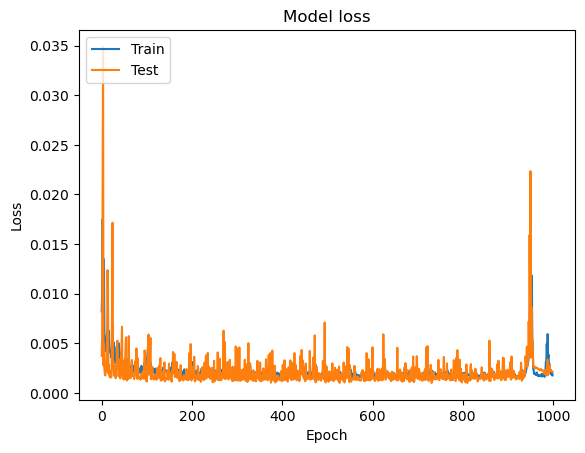

In [26]:
plt.plot(historylstm0.history['loss'])
plt.plot(historylstm0.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

8/8 [==============================] - 0s 4ms/step


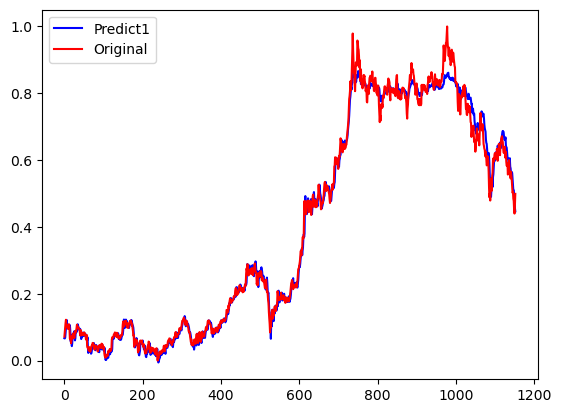

In [27]:
lstm0train  = lstm0.predict(x_train)
lstm0val = lstm0.predict(x_vaild)
lstm0pre = lstm0.predict(x_test)
pre = lstm0.predict(x_train)
pre1=lstm0.predict(x_vaild)
fc=np.concatenate((pre,pre1))
yreal=np.concatenate((y_train,y_vaild))
plt.figure(facecolor='white')
pd.Series(fc.reshape(-1)).plot(color='blue', label='Predict1')
pd.Series(yreal.reshape(-1)).plot(color='red', label='Original')
plt.legend()
plt.show()

C:\Users\terry\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\terry\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 20729 (\N{CJK UNIFIED IDEOGRAPH-50F9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


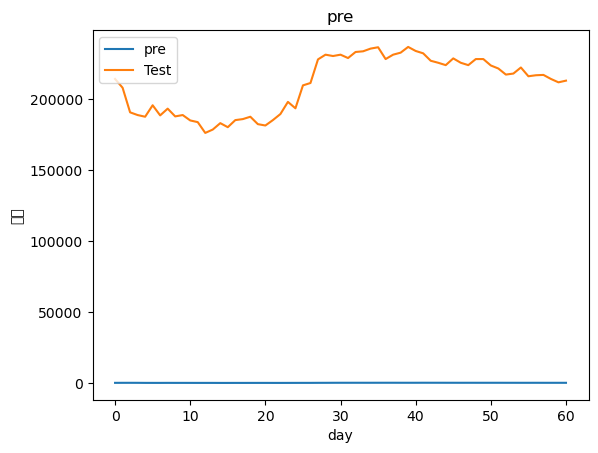

210982.65762649788

In [28]:
lstm0pre= scaler.inverse_transform(lstm0pre)#將資料轉換回來
y_test = scaler.inverse_transform(y_test.reshape(-1,1))
plt.figure()
plt.plot(lstm0pre)
plt.plot(y_test)
plt.title('pre')
plt.ylabel('股價')
plt.xlabel('day')
plt.legend(['pre', 'Test'], loc='upper left')
plt.show()
root_mean_squared_error(lstm0pre,y_test)

In [44]:
## 兩層LSTM BATCH數換成128 64
def lstm_model1(input_length, input_dim):

    d=0.3
    model= Sequential()
    model.add(LSTM(128,input_shape=(input_length, input_dim),return_sequences=True))
    model.add(Dropout(d))

    model.add(LSTM(64,input_shape=(input_length, input_dim),return_sequences=False))
    model.add(Dropout(d))
    
    model.add(Dense(1,activation='linear'))#linear / softmax(多分類) / sigmoid(二分法)

    # optimizer = tf.keras.optimizers.Adam(lr=0.00005)
    model.compile(loss='mse',optimizer='adam')#loss=mse/categorical_crossentropy
    return model 

In [32]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=300, monitor = 'val_loss')
    ]
filepath="lstm.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, mode='min',save_best_only=True)

call_backlist = [ my_callbacks,checkpoint]
callbacks=call_backlist
lstm1 = lstm_model1(10,5)
historylstm1 = lstm1.fit( x_train, y_train, batch_size=30,shuffle=False , epochs=1000,validation_data=(x_vaild,y_vaild),callbacks=call_backlist)
lstm1.summary()

Epoch 1/1000
28/31 [==========================>...] - ETA: 0s - loss: 0.0052
Epoch 1: val_loss improved from inf to 0.00627, saving model to lstm.best.hdf5
31/31 [==============================] - 4s 42ms/step - loss: 0.0057 - val_loss: 0.0063
Epoch 2/1000
29/31 [===========================>..] - ETA: 0s - loss: 0.0040
Epoch 2: val_loss improved from 0.00627 to 0.00187, saving model to lstm.best.hdf5
31/31 [==============================] - 1s 17ms/step - loss: 0.0043 - val_loss: 0.0019
Epoch 3/1000
29/31 [===========================>..] - ETA: 0s - loss: 0.0030   
Epoch 3: val_loss did not improve from 0.00187
31/31 [==============================] - 1s 16ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 4/1000
29/31 [===========================>..] - ETA: 0s - loss: 0.0031   
Epoch 4: val_loss did not improve from 0.00187
31/31 [==============================] - 1s 16ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 5/1000
28/31 [==========================>...] - ETA: 0s - loss: 0.0028  

28/31 [==========================>...] - ETA: 0s - loss: 0.0016    
Epoch 38: val_loss did not improve from 0.00124
31/31 [==============================] - 1s 20ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 39/1000
29/31 [===========================>..] - ETA: 0s - loss: 0.0015   
Epoch 39: val_loss did not improve from 0.00124
31/31 [==============================] - 1s 20ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 40/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0018   
Epoch 40: val_loss did not improve from 0.00124
31/31 [==============================] - 1s 20ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 41/1000
31/31 [==============================] - ETA: 0s - loss: 0.0021  
Epoch 41: val_loss did not improve from 0.00124
31/31 [==============================] - 1s 20ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 42/1000
31/31 [==============================] - ETA: 0s - loss: 0.0017  
Epoch 42: val_loss did not improve from 0.00124
31/31 [===========

31/31 [==============================] - ETA: 0s - loss: 0.0016   
Epoch 76: val_loss did not improve from 0.00124
31/31 [==============================] - 1s 22ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 77/1000
31/31 [==============================] - ETA: 0s - loss: 0.0016  
Epoch 77: val_loss did not improve from 0.00124
31/31 [==============================] - 1s 21ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 78/1000
31/31 [==============================] - ETA: 0s - loss: 0.0014   
Epoch 78: val_loss did not improve from 0.00124
31/31 [==============================] - 1s 21ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 79/1000
31/31 [==============================] - ETA: 0s - loss: 0.0020  
Epoch 79: val_loss did not improve from 0.00124
31/31 [==============================] - 1s 21ms/step - loss: 0.0020 - val_loss: 0.0043
Epoch 80/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0016   
Epoch 80: val_loss did not improve from 0.00124
31/31 [============

Epoch 114/1000
31/31 [==============================] - ETA: 0s - loss: 0.0019  
Epoch 114: val_loss did not improve from 0.00119
31/31 [==============================] - 1s 20ms/step - loss: 0.0019 - val_loss: 0.0046
Epoch 115/1000
29/31 [===========================>..] - ETA: 0s - loss: 0.0016   
Epoch 115: val_loss did not improve from 0.00119
31/31 [==============================] - 1s 20ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 116/1000
31/31 [==============================] - ETA: 0s - loss: 0.0019  
Epoch 116: val_loss did not improve from 0.00119
31/31 [==============================] - 1s 20ms/step - loss: 0.0019 - val_loss: 0.0055
Epoch 117/1000
29/31 [===========================>..] - ETA: 0s - loss: 0.0020   
Epoch 117: val_loss did not improve from 0.00119
31/31 [==============================] - 1s 19ms/step - loss: 0.0022 - val_loss: 0.0036
Epoch 118/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0019
Epoch 118: val_loss did not improve from 0.0011

31/31 [==============================] - 1s 20ms/step - loss: 0.0020 - val_loss: 0.0044
Epoch 152/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0017   
Epoch 152: val_loss did not improve from 0.00119
31/31 [==============================] - 1s 20ms/step - loss: 0.0018 - val_loss: 0.0044
Epoch 153/1000
29/31 [===========================>..] - ETA: 0s - loss: 0.0016   
Epoch 153: val_loss did not improve from 0.00119
31/31 [==============================] - 1s 19ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 154/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0014   
Epoch 154: val_loss did not improve from 0.00119
31/31 [==============================] - 1s 20ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 155/1000
29/31 [===========================>..] - ETA: 0s - loss: 0.0018
Epoch 155: val_loss did not improve from 0.00119
31/31 [==============================] - 1s 20ms/step - loss: 0.0019 - val_loss: 0.0051
Epoch 156/1000
29/31 [=================

30/31 [============================>.] - ETA: 0s - loss: 0.0018   
Epoch 189: val_loss did not improve from 0.00119
31/31 [==============================] - 1s 20ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 190/1000
31/31 [==============================] - ETA: 0s - loss: 0.0024   
Epoch 190: val_loss did not improve from 0.00119
31/31 [==============================] - 1s 20ms/step - loss: 0.0024 - val_loss: 0.0091
Epoch 191/1000
29/31 [===========================>..] - ETA: 0s - loss: 0.0016
Epoch 191: val_loss did not improve from 0.00119
31/31 [==============================] - 1s 19ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 192/1000
29/31 [===========================>..] - ETA: 0s - loss: 0.0019
Epoch 192: val_loss did not improve from 0.00119
31/31 [==============================] - 1s 20ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 193/1000
31/31 [==============================] - ETA: 0s - loss: 0.0013   
Epoch 193: val_loss did not improve from 0.00119
31/31 [=======

31/31 [==============================] - ETA: 0s - loss: 0.0017  
Epoch 226: val_loss did not improve from 0.00118
31/31 [==============================] - 1s 20ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 227/1000
28/31 [==========================>...] - ETA: 0s - loss: 0.0015   
Epoch 227: val_loss did not improve from 0.00118
31/31 [==============================] - 1s 19ms/step - loss: 0.0017 - val_loss: 0.0052
Epoch 228/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0013   
Epoch 228: val_loss did not improve from 0.00118
31/31 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 229/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0015   
Epoch 229: val_loss did not improve from 0.00118
31/31 [==============================] - 1s 19ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 230/1000
31/31 [==============================] - ETA: 0s - loss: 0.0015   
Epoch 230: val_loss did not improve from 0.00118
31/31 [==

Epoch 264/1000
31/31 [==============================] - ETA: 0s - loss: 0.0016  
Epoch 264: val_loss did not improve from 0.00118
31/31 [==============================] - 1s 21ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 265/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0019
Epoch 265: val_loss did not improve from 0.00118
31/31 [==============================] - 1s 20ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 266/1000
31/31 [==============================] - ETA: 0s - loss: 0.0016  
Epoch 266: val_loss did not improve from 0.00118
31/31 [==============================] - 1s 20ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 267/1000
31/31 [==============================] - ETA: 0s - loss: 0.0015  
Epoch 267: val_loss did not improve from 0.00118
31/31 [==============================] - 1s 21ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 268/1000
31/31 [==============================] - ETA: 0s - loss: 0.0013   
Epoch 268: val_loss did not improve from 0.00118

31/31 [==============================] - ETA: 0s - loss: 0.0012   
Epoch 301: val_loss did not improve from 0.00116
31/31 [==============================] - 1s 21ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 302/1000
31/31 [==============================] - ETA: 0s - loss: 0.0015  
Epoch 302: val_loss did not improve from 0.00116
31/31 [==============================] - 1s 21ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 303/1000
31/31 [==============================] - ETA: 0s - loss: 0.0015  
Epoch 303: val_loss did not improve from 0.00116
31/31 [==============================] - 1s 21ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 304/1000
31/31 [==============================] - ETA: 0s - loss: 0.0013   
Epoch 304: val_loss improved from 0.00116 to 0.00111, saving model to lstm.best.hdf5
31/31 [==============================] - 1s 22ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 305/1000
31/31 [==============================] - ETA: 0s - loss: 0.0012   
Epoch 305: val_loss did

28/31 [==========================>...] - ETA: 0s - loss: 0.0011    
Epoch 338: val_loss did not improve from 0.00110
31/31 [==============================] - 1s 21ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 339/1000
29/31 [===========================>..] - ETA: 0s - loss: 0.0012   
Epoch 339: val_loss did not improve from 0.00110
31/31 [==============================] - 1s 20ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 340/1000
29/31 [===========================>..] - ETA: 0s - loss: 0.0012   
Epoch 340: val_loss did not improve from 0.00110
31/31 [==============================] - 1s 20ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 341/1000
31/31 [==============================] - ETA: 0s - loss: 0.0012    
Epoch 341: val_loss did not improve from 0.00110
31/31 [==============================] - 1s 20ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 342/1000
31/31 [==============================] - ETA: 0s - loss: 0.0012   
Epoch 342: val_loss did not improve from 0.00110
31/31 

31/31 [==============================] - ETA: 0s - loss: 0.0011    
Epoch 375: val_loss did not improve from 0.00102
31/31 [==============================] - 1s 20ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 376/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0013   
Epoch 376: val_loss did not improve from 0.00102
31/31 [==============================] - 1s 20ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 377/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0014   
Epoch 377: val_loss did not improve from 0.00102
31/31 [==============================] - 1s 20ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 378/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0013   
Epoch 378: val_loss did not improve from 0.00102
31/31 [==============================] - 1s 20ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 379/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0013   
Epoch 379: val_loss did not improve from 0.00102
31/31 [

28/31 [==========================>...] - ETA: 0s - loss: 0.0018
Epoch 412: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 21ms/step - loss: 0.0019 - val_loss: 0.0057
Epoch 413/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0018  
Epoch 413: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 20ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 414/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 414: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 20ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 415/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0012   
Epoch 415: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 19ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 416/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0013   
Epoch 416: val_loss did not improve from 0.00101
31/31 [========

31/31 [==============================] - 1s 22ms/step - loss: 0.0015 - val_loss: 0.0043
Epoch 450/1000
31/31 [==============================] - ETA: 0s - loss: 0.0017  
Epoch 450: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 22ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 451/1000
31/31 [==============================] - ETA: 0s - loss: 0.0016  
Epoch 451: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 21ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 452/1000
31/31 [==============================] - ETA: 0s - loss: 0.0015
Epoch 452: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 21ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 453/1000
31/31 [==============================] - ETA: 0s - loss: 0.0016
Epoch 453: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 21ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 454/1000
31/31 [======================

31/31 [==============================] - ETA: 0s - loss: 0.0012   
Epoch 487: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 21ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 488/1000
31/31 [==============================] - ETA: 0s - loss: 0.0012   
Epoch 488: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 22ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 489/1000
31/31 [==============================] - ETA: 0s - loss: 0.0013   
Epoch 489: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 22ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 490/1000
31/31 [==============================] - ETA: 0s - loss: 0.0013   
Epoch 490: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 21ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 491/1000
31/31 [==============================] - ETA: 0s - loss: 0.0015   
Epoch 491: val_loss did not improve from 0.00101
31/31 [=

Epoch 525/1000
31/31 [==============================] - ETA: 0s - loss: 0.0015  
Epoch 525: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 21ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 526/1000
31/31 [==============================] - ETA: 0s - loss: 0.0013   
Epoch 526: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 21ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 527/1000
31/31 [==============================] - ETA: 0s - loss: 0.0012   
Epoch 527: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 21ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 528/1000
31/31 [==============================] - ETA: 0s - loss: 0.0012   
Epoch 528: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 21ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 529/1000
31/31 [==============================] - ETA: 0s - loss: 0.0011   
Epoch 529: val_loss did not improve from 0.

31/31 [==============================] - 1s 22ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 563/1000
31/31 [==============================] - ETA: 0s - loss: 0.0013   
Epoch 563: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 22ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 564/1000
31/31 [==============================] - ETA: 0s - loss: 0.0013  
Epoch 564: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 21ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 565/1000
31/31 [==============================] - ETA: 0s - loss: 0.0011   
Epoch 565: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 21ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 566/1000
31/31 [==============================] - ETA: 0s - loss: 0.0012   
Epoch 566: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 21ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 567/1000
31/31 [===============

31/31 [==============================] - ETA: 0s - loss: 0.0015
Epoch 600: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 22ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 601/1000
31/31 [==============================] - ETA: 0s - loss: 0.0012   
Epoch 601: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 21ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 602/1000
31/31 [==============================] - ETA: 0s - loss: 0.0014   
Epoch 602: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 21ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 603/1000
31/31 [==============================] - ETA: 0s - loss: 0.0012   
Epoch 603: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 21ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 604/1000
31/31 [==============================] - ETA: 0s - loss: 0.0011    
Epoch 604: val_loss did not improve from 0.00101
31/31 [===

31/31 [==============================] - 1s 22ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 638/1000
31/31 [==============================] - ETA: 0s - loss: 0.0010    
Epoch 638: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 22ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 639/1000
31/31 [==============================] - ETA: 0s - loss: 0.0011    
Epoch 639: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 22ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 640/1000
31/31 [==============================] - ETA: 0s - loss: 0.0012   
Epoch 640: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 21ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 641/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0010    
Epoch 641: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 22ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 642/1000
31/31 [===========

30/31 [============================>.] - ETA: 0s - loss: 0.0011    
Epoch 675: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 22ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 676/1000
31/31 [==============================] - ETA: 0s - loss: 0.0012   
Epoch 676: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 21ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 677/1000
31/31 [==============================] - ETA: 0s - loss: 0.0013   
Epoch 677: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 22ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 678/1000
31/31 [==============================] - ETA: 0s - loss: 0.0011    
Epoch 678: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 22ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 679/1000
31/31 [==============================] - ETA: 0s - loss: 0.0012   
Epoch 679: val_loss did not improve from 0.00101
31/31 

                                                                 
Total params: 118,081
Trainable params: 118,081
Non-trainable params: 0
_________________________________________________________________


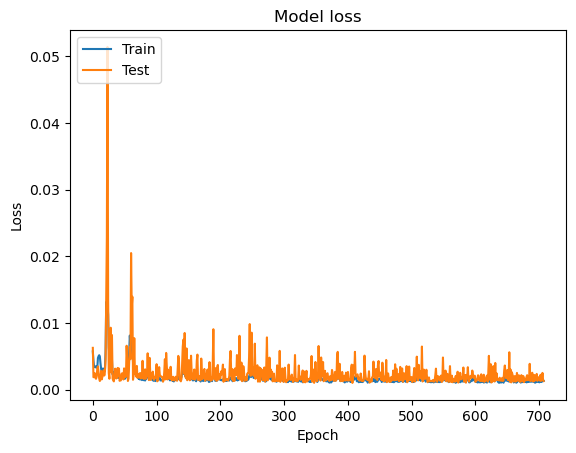

In [33]:
plt.plot(historylstm1.history['loss'])
plt.plot(historylstm1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

8/8 [==============================] - 0s 6ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

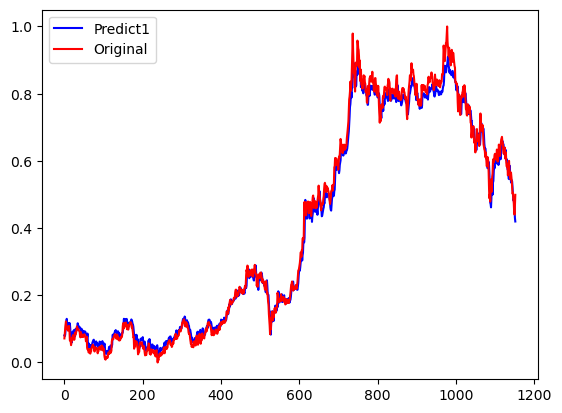

In [34]:
lstm1train  = lstm1.predict(x_train)
lstm1val = lstm1.predict(x_vaild)
lstm1pre = lstm1.predict(x_test)
pre = lstm1.predict(x_train)
pre1=lstm1.predict(x_vaild)
fc=np.concatenate((pre,pre1))
yreal=np.concatenate((y_train,y_vaild))
plt.figure(facecolor='white')
pd.Series(fc.reshape(-1)).plot(color='blue', label='Predict1')
pd.Series(yreal.reshape(-1)).plot(color='red', label='Original')
plt.legend()
plt.show

C:\Users\terry\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\terry\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 20729 (\N{CJK UNIFIED IDEOGRAPH-50F9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


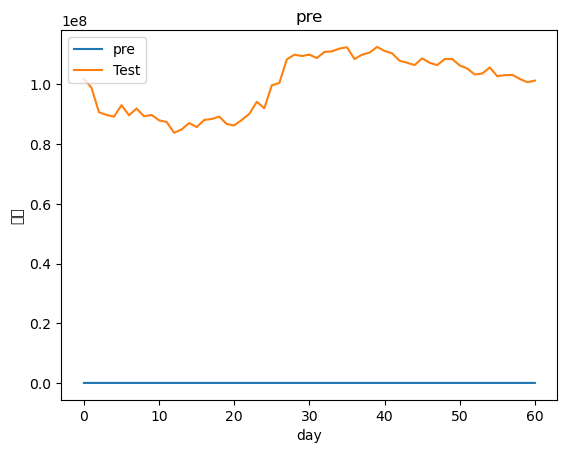

100428229.05942586

In [35]:
lstm1pre= scaler.inverse_transform(lstm1pre)#將資料轉換回來
y_test = scaler.inverse_transform(y_test.reshape(-1,1))
plt.figure()
plt.plot(lstm1pre)
plt.plot(y_test)
plt.title('pre')
plt.ylabel('股價')
plt.xlabel('day')
plt.legend(['pre', 'Test'], loc='upper left')
plt.show()
root_mean_squared_error(lstm1pre,y_test)

In [36]:
def lstm_model2(input_length, input_dim):

    d=0.3
    model= Sequential()
    model.add(LSTM(256,input_shape=(input_length, input_dim),return_sequences=True))
    model.add(Dropout(d))

    model.add(LSTM(128,input_shape=(input_length, input_dim),return_sequences=False))
    model.add(Dropout(d))
    model.add(Dense(16,activation='linear'))#linear / softmax(多分類) / sigmoid(二分法)
    model.add(Dropout(d))

    model.add(Dense(1,activation='linear'))#linear / softmax(多分類) / sigmoid(二分法)

    # optimizer = tf.keras.optimizers.Adam(lr=0.00005)
    model.compile(loss='mse',optimizer='adam')#loss=mse/categorical_crossentropy
    return model 

In [37]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=300, monitor = 'val_loss')
    ]
filepath="lstm.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, mode='min',save_best_only=True)

call_backlist = [ my_callbacks,checkpoint]
callbacks=call_backlist
lstm2 = lstm_model2(10,5)
historylstm2 = lstm2.fit( x_train, y_train, batch_size=30,shuffle=False , epochs=1000,validation_data=(x_vaild,y_vaild),callbacks=call_backlist)
lstm2.summary()

Epoch 1/1000
31/31 [==============================] - ETA: 0s - loss: 0.0139
Epoch 1: val_loss improved from inf to 0.00237, saving model to lstm.best.hdf5
31/31 [==============================] - 5s 60ms/step - loss: 0.0139 - val_loss: 0.0024
Epoch 2/1000
31/31 [==============================] - ETA: 0s - loss: 0.0158
Epoch 2: val_loss did not improve from 0.00237
31/31 [==============================] - 1s 37ms/step - loss: 0.0158 - val_loss: 0.0042
Epoch 3/1000
31/31 [==============================] - ETA: 0s - loss: 0.0144
Epoch 3: val_loss did not improve from 0.00237
31/31 [==============================] - 1s 38ms/step - loss: 0.0144 - val_loss: 0.0058
Epoch 4/1000
31/31 [==============================] - ETA: 0s - loss: 0.0155
Epoch 4: val_loss did not improve from 0.00237
31/31 [==============================] - 1s 40ms/step - loss: 0.0155 - val_loss: 0.0043
Epoch 5/1000
31/31 [==============================] - ETA: 0s - loss: 0.0113
Epoch 5: val_loss did not improve from 0.00

Epoch 39/1000
31/31 [==============================] - ETA: 0s - loss: 0.0066
Epoch 39: val_loss did not improve from 0.00128
31/31 [==============================] - 1s 46ms/step - loss: 0.0066 - val_loss: 0.0014
Epoch 40/1000
31/31 [==============================] - ETA: 0s - loss: 0.0079
Epoch 40: val_loss did not improve from 0.00128
31/31 [==============================] - 1s 47ms/step - loss: 0.0079 - val_loss: 0.0018
Epoch 41/1000
31/31 [==============================] - ETA: 0s - loss: 0.0077
Epoch 41: val_loss did not improve from 0.00128
31/31 [==============================] - 1s 45ms/step - loss: 0.0077 - val_loss: 0.0026
Epoch 42/1000
31/31 [==============================] - ETA: 0s - loss: 0.0111
Epoch 42: val_loss did not improve from 0.00128
31/31 [==============================] - 1s 47ms/step - loss: 0.0111 - val_loss: 0.0051
Epoch 43/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0090
Epoch 43: val_loss did not improve from 0.00128
31/31 [===========

31/31 [==============================] - ETA: 0s - loss: 0.0051
Epoch 77: val_loss did not improve from 0.00128
31/31 [==============================] - 1s 48ms/step - loss: 0.0051 - val_loss: 0.0020
Epoch 78/1000
31/31 [==============================] - ETA: 0s - loss: 0.0039
Epoch 78: val_loss did not improve from 0.00128
31/31 [==============================] - 1s 47ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 79/1000
31/31 [==============================] - ETA: 0s - loss: 0.0044
Epoch 79: val_loss did not improve from 0.00128
31/31 [==============================] - 1s 48ms/step - loss: 0.0044 - val_loss: 0.0015
Epoch 80/1000
31/31 [==============================] - ETA: 0s - loss: 0.0053
Epoch 80: val_loss did not improve from 0.00128
31/31 [==============================] - 1s 48ms/step - loss: 0.0053 - val_loss: 0.0017
Epoch 81/1000
31/31 [==============================] - ETA: 0s - loss: 0.0038
Epoch 81: val_loss did not improve from 0.00128
31/31 [=========================

30/31 [============================>.] - ETA: 0s - loss: 0.0048
Epoch 115: val_loss did not improve from 0.00127
31/31 [==============================] - 2s 50ms/step - loss: 0.0049 - val_loss: 0.0021
Epoch 116/1000
31/31 [==============================] - ETA: 0s - loss: 0.0052
Epoch 116: val_loss did not improve from 0.00127
31/31 [==============================] - 2s 49ms/step - loss: 0.0052 - val_loss: 0.0026
Epoch 117/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0045
Epoch 117: val_loss did not improve from 0.00127
31/31 [==============================] - 1s 48ms/step - loss: 0.0047 - val_loss: 0.0019
Epoch 118/1000
31/31 [==============================] - ETA: 0s - loss: 0.0036
Epoch 118: val_loss improved from 0.00127 to 0.00119, saving model to lstm.best.hdf5
31/31 [==============================] - 2s 49ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 119/1000
31/31 [==============================] - ETA: 0s - loss: 0.0039
Epoch 119: val_loss did not improve 

31/31 [==============================] - 2s 49ms/step - loss: 0.0064 - val_loss: 0.0047
Epoch 153/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0043
Epoch 153: val_loss did not improve from 0.00108
31/31 [==============================] - 2s 55ms/step - loss: 0.0044 - val_loss: 0.0032
Epoch 154/1000
31/31 [==============================] - ETA: 0s - loss: 0.0035
Epoch 154: val_loss did not improve from 0.00108
31/31 [==============================] - 2s 50ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 155/1000
31/31 [==============================] - ETA: 0s - loss: 0.0038
Epoch 155: val_loss did not improve from 0.00108
31/31 [==============================] - 1s 48ms/step - loss: 0.0038 - val_loss: 0.0028
Epoch 156/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0045
Epoch 156: val_loss did not improve from 0.00108
31/31 [==============================] - 2s 51ms/step - loss: 0.0047 - val_loss: 0.0048
Epoch 157/1000
31/31 [==========================

31/31 [==============================] - 1s 47ms/step - loss: 0.0086 - val_loss: 0.0032
Epoch 191/1000
31/31 [==============================] - ETA: 0s - loss: 0.0090
Epoch 191: val_loss did not improve from 0.00108
31/31 [==============================] - 1s 47ms/step - loss: 0.0090 - val_loss: 0.0034
Epoch 192/1000
31/31 [==============================] - ETA: 0s - loss: 0.0084
Epoch 192: val_loss did not improve from 0.00108
31/31 [==============================] - 1s 48ms/step - loss: 0.0084 - val_loss: 0.0029
Epoch 193/1000
31/31 [==============================] - ETA: 0s - loss: 0.0107
Epoch 193: val_loss did not improve from 0.00108
31/31 [==============================] - 1s 47ms/step - loss: 0.0107 - val_loss: 0.0056
Epoch 194/1000
31/31 [==============================] - ETA: 0s - loss: 0.0065
Epoch 194: val_loss did not improve from 0.00108
31/31 [==============================] - 1s 47ms/step - loss: 0.0065 - val_loss: 0.0028
Epoch 195/1000
30/31 [==========================

31/31 [==============================] - 1s 48ms/step - loss: 0.0057 - val_loss: 0.0025
Epoch 229/1000
31/31 [==============================] - ETA: 0s - loss: 0.0078
Epoch 229: val_loss did not improve from 0.00108
31/31 [==============================] - 1s 47ms/step - loss: 0.0078 - val_loss: 0.0042
Epoch 230/1000
31/31 [==============================] - ETA: 0s - loss: 0.0071
Epoch 230: val_loss did not improve from 0.00108
31/31 [==============================] - 1s 46ms/step - loss: 0.0071 - val_loss: 0.0038
Epoch 231/1000
31/31 [==============================] - ETA: 0s - loss: 0.0094
Epoch 231: val_loss did not improve from 0.00108
31/31 [==============================] - 1s 47ms/step - loss: 0.0094 - val_loss: 0.0058
Epoch 232/1000
31/31 [==============================] - ETA: 0s - loss: 0.0056
Epoch 232: val_loss did not improve from 0.00108
31/31 [==============================] - 1s 46ms/step - loss: 0.0056 - val_loss: 0.0028
Epoch 233/1000
31/31 [==========================

31/31 [==============================] - 1s 46ms/step - loss: 0.0057 - val_loss: 0.0046
Epoch 267/1000
31/31 [==============================] - ETA: 0s - loss: 0.0064
Epoch 267: val_loss did not improve from 0.00108
31/31 [==============================] - 1s 45ms/step - loss: 0.0064 - val_loss: 0.0047
Epoch 268/1000
31/31 [==============================] - ETA: 0s - loss: 0.0052
Epoch 268: val_loss did not improve from 0.00108
31/31 [==============================] - 1s 47ms/step - loss: 0.0052 - val_loss: 0.0022
Epoch 269/1000
31/31 [==============================] - ETA: 0s - loss: 0.0072
Epoch 269: val_loss did not improve from 0.00108
31/31 [==============================] - 1s 45ms/step - loss: 0.0072 - val_loss: 0.0024
Epoch 270/1000
31/31 [==============================] - ETA: 0s - loss: 0.0067
Epoch 270: val_loss did not improve from 0.00108
31/31 [==============================] - 1s 45ms/step - loss: 0.0067 - val_loss: 0.0030
Epoch 271/1000
31/31 [==========================

31/31 [==============================] - 1s 47ms/step - loss: 0.0051 - val_loss: 0.0022
Epoch 305/1000
31/31 [==============================] - ETA: 0s - loss: 0.0059
Epoch 305: val_loss did not improve from 0.00108
31/31 [==============================] - 1s 46ms/step - loss: 0.0059 - val_loss: 0.0037
Epoch 306/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0054
Epoch 306: val_loss did not improve from 0.00108
31/31 [==============================] - 2s 52ms/step - loss: 0.0053 - val_loss: 0.0037
Epoch 307/1000
31/31 [==============================] - ETA: 0s - loss: 0.0052
Epoch 307: val_loss did not improve from 0.00108
31/31 [==============================] - 1s 47ms/step - loss: 0.0052 - val_loss: 0.0042
Epoch 308/1000
31/31 [==============================] - ETA: 0s - loss: 0.0046
Epoch 308: val_loss did not improve from 0.00108
31/31 [==============================] - 1s 48ms/step - loss: 0.0046 - val_loss: 0.0028
Epoch 309/1000
31/31 [==========================

31/31 [==============================] - 2s 50ms/step - loss: 0.0070 - val_loss: 0.0060
Epoch 343/1000
31/31 [==============================] - ETA: 0s - loss: 0.0066
Epoch 343: val_loss did not improve from 0.00108
31/31 [==============================] - 2s 50ms/step - loss: 0.0066 - val_loss: 0.0050
Epoch 344/1000
31/31 [==============================] - ETA: 0s - loss: 0.0063
Epoch 344: val_loss did not improve from 0.00108
31/31 [==============================] - 2s 49ms/step - loss: 0.0063 - val_loss: 0.0027
Epoch 345/1000
31/31 [==============================] - ETA: 0s - loss: 0.0070
Epoch 345: val_loss did not improve from 0.00108
31/31 [==============================] - 2s 49ms/step - loss: 0.0070 - val_loss: 0.0031
Epoch 346/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0074
Epoch 346: val_loss did not improve from 0.00108
31/31 [==============================] - 2s 49ms/step - loss: 0.0073 - val_loss: 0.0032
Epoch 347/1000
31/31 [==========================

31/31 [==============================] - 2s 51ms/step - loss: 0.0056 - val_loss: 0.0032
Epoch 381/1000
31/31 [==============================] - ETA: 0s - loss: 0.0088
Epoch 381: val_loss did not improve from 0.00108
31/31 [==============================] - 1s 46ms/step - loss: 0.0088 - val_loss: 0.0040
Epoch 382/1000
31/31 [==============================] - ETA: 0s - loss: 0.0080
Epoch 382: val_loss did not improve from 0.00108
31/31 [==============================] - 1s 45ms/step - loss: 0.0080 - val_loss: 0.0135
Epoch 383/1000
31/31 [==============================] - ETA: 0s - loss: 0.0096
Epoch 383: val_loss did not improve from 0.00108
31/31 [==============================] - 1s 45ms/step - loss: 0.0096 - val_loss: 0.0063
Epoch 384/1000
31/31 [==============================] - ETA: 0s - loss: 0.0055
Epoch 384: val_loss did not improve from 0.00108
31/31 [==============================] - 1s 45ms/step - loss: 0.0055 - val_loss: 0.0020
Epoch 385/1000
31/31 [==========================

31/31 [==============================] - 1s 47ms/step - loss: 0.0054 - val_loss: 0.0033
Epoch 419/1000
31/31 [==============================] - ETA: 0s - loss: 0.0061
Epoch 419: val_loss did not improve from 0.00108
31/31 [==============================] - 1s 45ms/step - loss: 0.0061 - val_loss: 0.0048
Epoch 420/1000
31/31 [==============================] - ETA: 0s - loss: 0.0051
Epoch 420: val_loss did not improve from 0.00108
31/31 [==============================] - 1s 45ms/step - loss: 0.0051 - val_loss: 0.0026
Epoch 421/1000
31/31 [==============================] - ETA: 0s - loss: 0.0066
Epoch 421: val_loss did not improve from 0.00108
31/31 [==============================] - 1s 46ms/step - loss: 0.0066 - val_loss: 0.0041
Epoch 422/1000
31/31 [==============================] - ETA: 0s - loss: 0.0050
Epoch 422: val_loss did not improve from 0.00108
31/31 [==============================] - 1s 46ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 423/1000
31/31 [==========================

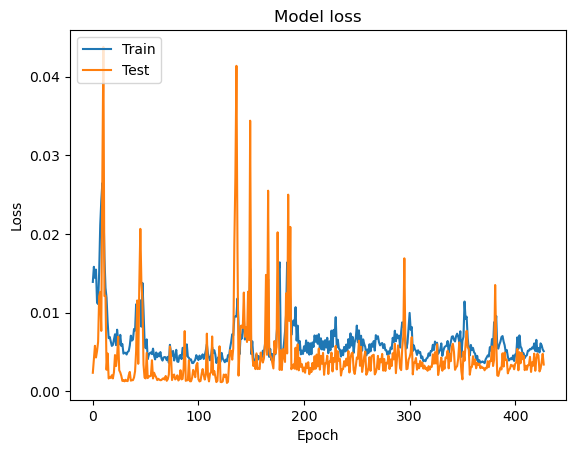

In [38]:
plt.plot(historylstm2.history['loss'])
plt.plot(historylstm2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

8/8 [==============================] - 0s 15ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

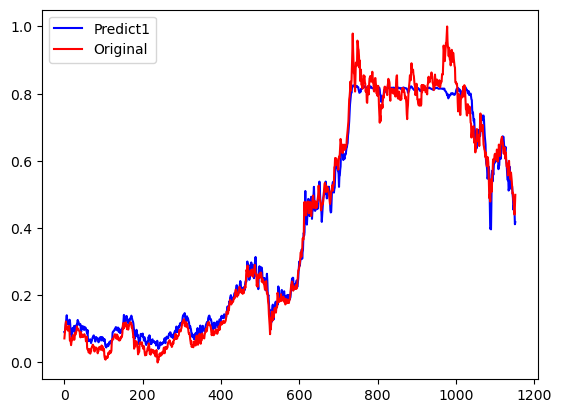

In [39]:
lstm2train  = lstm2.predict(x_train)
lstm2val = lstm2.predict(x_vaild)
lstm2pre = lstm2.predict(x_test)
pre = lstm2.predict(x_train)
pre1=lstm2.predict(x_vaild)
fc=np.concatenate((pre,pre1))
yreal=np.concatenate((y_train,y_vaild))
plt.figure(facecolor='white')
pd.Series(fc.reshape(-1)).plot(color='blue', label='Predict1')
pd.Series(yreal.reshape(-1)).plot(color='red', label='Original')
plt.legend()
plt.show

2/2 [==============================] - 0s 15ms/step


C:\Users\terry\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\terry\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 20729 (\N{CJK UNIFIED IDEOGRAPH-50F9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


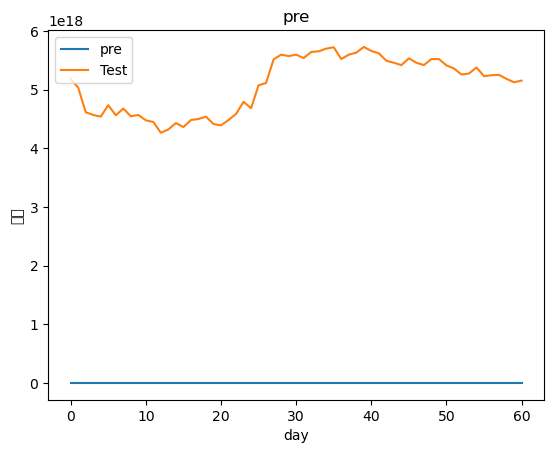

5.112486008521865e+18

In [43]:
lstm2pre = lstm2.predict(x_test)
pre= scaler.inverse_transform(lstm2pre)#將資料轉換回來
y_test = scaler.inverse_transform(y_test.reshape(-1,1))
plt.figure()
plt.plot(pre)
plt.plot(y_test)
plt.title('pre')
plt.ylabel('股價')
plt.xlabel('day')
plt.legend(['pre', 'Test'], loc='upper left')
plt.show()
root_mean_squared_error(pre,y_test)